# 現実写真のみ、文字なし、固有名詞全部なし、キャプション無し、ほかの画像の大喜利

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [2]:
EXPERIENCE_NUMBER = "004"

USE_UNREAL_IMAGE = False
USE_WORD_IMAGE = False
USE_UNIQUE_NOUN_BOKE = False
USE_CAPTION = False
USE_MISS_BOKE = True

EPOCH = 25
BATCH_SIZE = 256

RESULT_DIR = f"../../results/Boke_Judge/{EXPERIENCE_NUMBER}/"
if not os.path.exists("../../results/Boke_Judge/"):
    os.mkdir("../../results/Boke_Judge/")
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)

DATA_DIR = "../../datas/boke_data_assemble/"
CLIP_IMAGE_FEATURE_DIR = "../../datas/encoded/clip_image_feature/"
CLIP_SENTENCE_FEATURE_DIR = "../../datas/encoded/clip_sentence_feature/"
LUKE_SENTENCE_FEATURE_DIR = "../../datas/encoded/luke_sentence_feature/"

# データセットの作成(初回のみ実行)

In [3]:
boke_datas = list()
caption_datas = list()

max_num_boke = 0
for JP in tqdm(os.listdir(DATA_DIR)):
    N = int(JP.split(".")[0])

    with open(f"{DATA_DIR}{JP}", "r") as f:
        a = json.load(f)

    image_information = a["image_infomation"]
    is_photographic_probability = image_information["is_photographic_probability"]
    ja_caption = image_information["ja_caption"]
    ocr = image_information["ocr"]

    # 現実写真以外を除去
    if not USE_UNREAL_IMAGE:
        if is_photographic_probability < 0.8: continue
        
    # 文字のある画像を除去
    if not USE_WORD_IMAGE:
        if len(ocr) != 0: continue

    bokes = a["bokes"]

    max_num_boke = max(max_num_boke, len(a["bokes"]))
    for i, B in enumerate(bokes):

        # 固有名詞を含む大喜利を除去
        if not USE_UNIQUE_NOUN_BOKE:
            if len(B["unique_nouns"]) != 0: continue

        boke_datas.append({
            "boke_number": int(f"1{N:07}{i:05}"),
            "image_number": int(f"3{N:07}")
        })

    caption_datas.append({
        "caption_number": int(f"2{N:07}"),
        "image_number": int(f"3{N:07}")
    })

len(boke_datas), len(caption_datas)

100%|██████████| 602566/602566 [03:15<00:00, 3078.98it/s]


(2183708, 230990)

In [4]:
train_boke_datas, test_boke_datas = train_test_split(boke_datas, test_size = 0.01)
train_caption_datas, test_caption_datas = train_test_split(caption_datas, test_size = 0.01)

with open(f"{RESULT_DIR}train_boke_datas.json", "w") as f:
    json.dump(train_boke_datas, f)
with open(f"{RESULT_DIR}train_caption_datas.json", "w") as f:
    json.dump(train_caption_datas, f)

with open(f"{RESULT_DIR}test_boke_datas.json", "w") as f:
    json.dump(test_boke_datas, f)
with open(f"{RESULT_DIR}test_caption_datas.json", "w") as f:
    json.dump(test_caption_datas, f)

# モデルの学習

In [5]:
with open(f"{RESULT_DIR}train_boke_datas.json", "r") as f:
    train_boke_datas = json.load(f)
with open(f"{RESULT_DIR}train_caption_datas.json", "r") as f:
    train_caption_datas = json.load(f)

with open(f"{RESULT_DIR}test_boke_datas.json", "r") as f:
    test_boke_datas = json.load(f)
with open(f"{RESULT_DIR}test_caption_datas.json", "r") as f:
    test_caption_datas = json.load(f)

len(train_boke_datas), len(train_caption_datas), len(test_boke_datas), len(test_caption_datas)

(2161870, 228680, 21838, 2310)

In [6]:
def make_dataloader(boke_datas, caption_datas):
    class LoadNpyDataset(Dataset):
        def __init__(self, image_file_numbers, sentence_file_numbers, teacher_signals):
            if len(image_file_numbers) != len(sentence_file_numbers) and len(sentence_file_numbers) != len(teacher_signals):
                raise ValueError("データリストの長さが一致しません")

            self.image_file_numbers = image_file_numbers
            self.sentence_file_numbers = sentence_file_numbers
            self.teacher_signals = teacher_signals

        def __len__(self):
            return len(self.teacher_signals)

        def __getitem__(self, idx):
            clip_image_feature = np.load(f"{CLIP_IMAGE_FEATURE_DIR}{self.image_file_numbers[idx]}.npy")
            clip_sentence_feature = np.load(f"{CLIP_SENTENCE_FEATURE_DIR}{self.sentence_file_numbers[idx]}.npy")
            luke_sentence_feature = np.load(f"{LUKE_SENTENCE_FEATURE_DIR}{self.sentence_file_numbers[idx]}.npy")
            teacher_signal = self.teacher_signals[idx]

            return clip_image_feature, clip_sentence_feature, luke_sentence_feature, teacher_signal

    def collate_fn_tf(batch):
        clip_image_features = np.array([B[0] for B in batch])
        clip_sentence_features = np.array([B[1] for B in batch])
        luke_sentence_features = np.array([B[2] for B in batch])
        teacher_signals = np.array([float(B[3]) for B in batch])
        
        return clip_image_features, clip_sentence_features, luke_sentence_features, teacher_signals

    #
    image_file_numbers = list()
    sentence_file_numbers = list()
    teacher_signals = list()

    for D in boke_datas:
        image_file_numbers.append(D["image_number"])
        sentence_file_numbers.append(D["boke_number"])
        teacher_signals.append(1)

    if USE_CAPTION:
        for D in caption_datas:
            image_file_numbers.append(D["image_number"])
            sentence_file_numbers.append(D["caption_number"])
            teacher_signals.append(0)
    
    if USE_MISS_BOKE:
        miss_boke_datas = list()
        tmp_idx = np.random.randint(0, len(boke_datas), size = (len(boke_datas), ))
        for i, idx in tqdm(enumerate(tmp_idx)):
            tmp_boke_number = boke_datas[idx]["boke_number"]
            while str(tmp_boke_number)[:7] == str(boke_datas[i]["boke_number"])[:7]:
                idx = np.random.randint(0, len(boke_datas))
                tmp_boke_number = boke_datas[idx]["boke_number"]

            miss_boke_datas.append({
                "boke_number": tmp_boke_number,
                "image_number": boke_datas[i]["image_number"]
            })
        
        for D in miss_boke_datas:
            image_file_numbers.append(D["image_number"])
            sentence_file_numbers.append(D["boke_number"])
            teacher_signals.append(0)
    
    print(f"num data: {len(teacher_signals)}")

    tmp = list(zip(image_file_numbers, sentence_file_numbers, teacher_signals))
    np.random.shuffle(tmp)
    image_file_numbers, sentence_file_numbers, teacher_signals = zip(*tmp)

    dataset = LoadNpyDataset(image_file_numbers, sentence_file_numbers, teacher_signals)
    dataloader = DataLoader(
        dataset, 
        batch_size = BATCH_SIZE, 
        num_workers = 10, 
        collate_fn = collate_fn_tf
    )

    return dataloader

train_dataloader = make_dataloader(train_boke_datas, train_caption_datas)
test_dataloader = make_dataloader(test_boke_datas, test_caption_datas)

#
CIF, CSF, LSF, TS = next(iter(train_dataloader))
CIF.shape, CSF.shape, LSF.shape, TS.shape

2161870it [00:01, 1092109.96it/s]


num data: 4323740


21838it [00:00, 95323.50it/s]

num data: 43676


((256, 512), (256, 512), (256, 768), (256,))

In [7]:
class CustomModel(nn.Module):
    def __init__(self, cif_dim, csf_dim, lsf_dim):
        super(CustomModel, self).__init__()
        # 入力次元を設定
        self.cif_dim = cif_dim
        self.csf_dim = csf_dim
        self.lsf_dim = lsf_dim
        
        # 全結合層
        self.fc1 = nn.Linear(cif_dim + csf_dim + lsf_dim, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.output_layer = nn.Linear(1024, 1)
        
    def forward(self, cif, csf, lsf):
        # 入力を結合
        x = torch.cat([cif, csf, lsf], dim=1)
        # 全結合層 + LeakyReLU
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        # 出力層 + シグモイド
        output = torch.sigmoid(self.output_layer(x))
        return output

model = CustomModel(CIF.shape[1], CSF.shape[1], LSF.shape[1])
print(model)

CustomModel(
  (fc1): Linear(in_features=1792, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1024, out_features=1, bias=True)
)


In [8]:
def train_step(model, optimizer, batch_data, batch_labels):
    model.train()  # モデルを訓練モードに設定
    optimizer.zero_grad()  # 勾配を初期化
    outputs = model(*batch_data).float()  # モデルで予測を計算
    loss = nn.BCELoss()(outputs, batch_labels.float())  # 損失関数（バイナリクロスエントロピー）
    accuracy = ((outputs > 0.5).float() == batch_labels).float().mean()  # 精度計算
    loss.backward()  # 勾配を計算
    optimizer.step()  # パラメータ更新
    return loss.item(), accuracy.item()

def evaluate(model, batch_data, batch_labels):
    model.eval()  # モデルを評価モードに設定
    with torch.no_grad():  # 評価時に勾配計算を行わない
        outputs = model(*batch_data)
        loss = nn.BCELoss()(outputs, batch_labels)
        accuracy = ((outputs > 0.5).float() == batch_labels).float().mean()
    return loss.item(), accuracy.item()

train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

model = CustomModel(CIF.shape[1], CSF.shape[1], LSF.shape[1])
optimizer = optim.AdamW(model.parameters(), lr = 0.0001)

# 訓練・評価ループ
for epoch in range(EPOCH):
    # 訓練
    train_loss_obj = 0.0
    train_accuracy_obj = 0.0
    model.train()  # 訓練モード
    train_dataloader = make_dataloader(train_boke_datas, train_caption_datas)
    pb = tqdm(train_dataloader, desc = f"Epoch {epoch+1}/{EPOCH}")
    
    for CIF, CSF, LSF, TS in pb:
        CIF, CSF, LSF, TS = torch.tensor(CIF), torch.tensor(CSF), torch.tensor(LSF), torch.tensor(TS)
        batch_data = (CIF, CSF, LSF)  # 入力データ
        batch_labels = TS.unsqueeze(1)  # 出力ラベル（shape: [batch_size, 1]）
        
        loss, accuracy = train_step(model, optimizer, batch_data, batch_labels)
        train_loss_obj += loss
        train_accuracy_obj += accuracy
        pb.set_postfix({"train_loss": train_loss_obj / (pb.n + 1), "train_accuracy": train_accuracy_obj / (pb.n + 1)})

    # 訓練後の損失と精度
    train_loss = train_loss_obj / len(train_dataloader)
    train_accuracy = train_accuracy_obj / len(train_dataloader)

    # テスト
    test_loss_obj = 0.0
    test_accuracy_obj = 0.0
    model.eval()  # 評価モード
    test_dataloader = make_dataloader(test_boke_datas, test_caption_datas)
    pb = tqdm(test_dataloader, desc = "Evaluating")

    for CIF, CSF, LSF, TS in pb:
        CIF, CSF, LSF, TS = torch.tensor(CIF).float(), torch.tensor(CSF).float(), torch.tensor(LSF).float(), torch.tensor(TS).float()
        batch_data = (CIF, CSF, LSF)
        batch_labels = TS.unsqueeze(1).float()
        
        loss, accuracy = evaluate(model, batch_data, batch_labels)
        test_loss_obj += loss
        test_accuracy_obj += accuracy
        pb.set_postfix({"test_loss": test_loss_obj / (pb.n + 1), "test_accuracy": test_accuracy_obj / (pb.n + 1)})

    # テスト後の損失と精度
    test_loss = test_loss_obj / len(test_dataloader)
    test_accuracy = test_accuracy_obj / len(test_dataloader)

    # 結果表示
    print(f"Epoch: {epoch+1}/{EPOCH}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # 履歴の保存
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

# 結果をJSONファイルに保存
with open(f"{RESULT_DIR}history.json", "w") as f:
    json.dump({
        "train_loss": train_loss_history,
        "train_accuracy": train_accuracy_history,
        "test_loss": test_loss_history,
        "test_accuracy": test_accuracy_history
    }, f)


2161870it [00:01, 1111476.25it/s]


num data: 4323740


Epoch 1/25: 100%|██████████| 16890/16890 [08:59<00:00, 31.32it/s, train_loss=0.62, train_accuracy=0.644] 
21838it [00:00, 160667.98it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:06<00:00, 25.53it/s, test_loss=0.628, test_accuracy=0.701]


Epoch: 1/25, Train Loss: 0.6203, Train Accuracy: 0.6439, Test Loss: 0.5983, Test Accuracy: 0.6686


2161870it [00:06, 357819.17it/s] 


num data: 4323740


Epoch 2/25: 100%|██████████| 16890/16890 [09:05<00:00, 30.95it/s, train_loss=0.584, train_accuracy=0.683]
21838it [00:00, 1284231.04it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:02<00:00, 59.34it/s, test_loss=0.579, test_accuracy=0.693] 


Epoch: 2/25, Train Loss: 0.5836, Train Accuracy: 0.6827, Test Loss: 0.5760, Test Accuracy: 0.6891


2161870it [00:02, 1073640.58it/s]


num data: 4323740


Epoch 3/25: 100%|██████████| 16890/16890 [06:37<00:00, 42.50it/s, train_loss=0.566, train_accuracy=0.698]
21838it [00:00, 1220618.48it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:02<00:00, 59.55it/s, test_loss=0.569, test_accuracy=0.7]   


Epoch: 3/25, Train Loss: 0.5657, Train Accuracy: 0.6980, Test Loss: 0.5652, Test Accuracy: 0.6963


2161870it [00:02, 1072837.12it/s]


num data: 4323740


Epoch 4/25: 100%|██████████| 16890/16890 [06:30<00:00, 43.28it/s, train_loss=0.552, train_accuracy=0.709]
21838it [00:00, 1326870.69it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:03<00:00, 56.15it/s, test_loss=0.559, test_accuracy=0.704] 


Epoch: 4/25, Train Loss: 0.5523, Train Accuracy: 0.7092, Test Loss: 0.5586, Test Accuracy: 0.7043


2161870it [00:01, 1092830.85it/s]


num data: 4323740


Epoch 5/25: 100%|██████████| 16890/16890 [08:05<00:00, 34.78it/s, train_loss=0.541, train_accuracy=0.718]
21838it [00:00, 1387238.72it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:03<00:00, 53.73it/s, test_loss=0.597, test_accuracy=0.753] 


Epoch: 5/25, Train Loss: 0.5406, Train Accuracy: 0.7179, Test Loss: 0.5585, Test Accuracy: 0.7041


2161870it [00:01, 1086570.17it/s]


num data: 4323740


Epoch 6/25: 100%|██████████| 16890/16890 [06:33<00:00, 42.87it/s, train_loss=0.53, train_accuracy=0.726] 
21838it [00:00, 1252584.08it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:03<00:00, 52.81it/s, test_loss=0.559, test_accuracy=0.712] 


Epoch: 6/25, Train Loss: 0.5300, Train Accuracy: 0.7259, Test Loss: 0.5558, Test Accuracy: 0.7081


2161870it [00:02, 1026809.84it/s]


num data: 4323740


Epoch 7/25: 100%|██████████| 16890/16890 [06:34<00:00, 42.83it/s, train_loss=0.52, train_accuracy=0.733] 
21838it [00:00, 1282576.64it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:03<00:00, 52.99it/s, test_loss=0.551, test_accuracy=0.71]  


Epoch: 7/25, Train Loss: 0.5198, Train Accuracy: 0.7332, Test Loss: 0.5510, Test Accuracy: 0.7097


2161870it [00:02, 1056835.90it/s]


num data: 4323740


Epoch 8/25: 100%|██████████| 16890/16890 [08:52<00:00, 31.75it/s, train_loss=0.51, train_accuracy=0.74]  
21838it [00:00, 191004.41it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:04<00:00, 36.71it/s, test_loss=0.571, test_accuracy=0.736]


Epoch: 8/25, Train Loss: 0.5102, Train Accuracy: 0.7398, Test Loss: 0.5539, Test Accuracy: 0.7141


2161870it [00:04, 456514.19it/s]


num data: 4323740


Epoch 9/25: 100%|██████████| 16890/16890 [08:08<00:00, 34.54it/s, train_loss=0.502, train_accuracy=0.745]
21838it [00:00, 1317632.32it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:03<00:00, 54.13it/s, test_loss=0.599, test_accuracy=0.773] 


Epoch: 9/25, Train Loss: 0.5015, Train Accuracy: 0.7451, Test Loss: 0.5538, Test Accuracy: 0.7138


2161870it [00:01, 1085886.77it/s]


num data: 4323740


Epoch 10/25: 100%|██████████| 16890/16890 [05:43<00:00, 49.16it/s, train_loss=0.493, train_accuracy=0.751]
21838it [00:00, 1439225.84it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:02<00:00, 58.58it/s, test_loss=0.595, test_accuracy=0.758] 


Epoch: 10/25, Train Loss: 0.4928, Train Accuracy: 0.7509, Test Loss: 0.5601, Test Accuracy: 0.7138


2161870it [00:02, 1077521.17it/s]


num data: 4323740


Epoch 11/25: 100%|██████████| 16890/16890 [08:45<00:00, 32.14it/s, train_loss=0.485, train_accuracy=0.756]
21838it [00:00, 1294357.53it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:02<00:00, 58.42it/s, test_loss=0.582, test_accuracy=0.732] 


Epoch: 11/25, Train Loss: 0.4846, Train Accuracy: 0.7561, Test Loss: 0.5681, Test Accuracy: 0.7148


2161870it [00:02, 1078934.59it/s]


num data: 4323740


Epoch 12/25: 100%|██████████| 16890/16890 [05:30<00:00, 51.04it/s, train_loss=0.477, train_accuracy=0.761]
21838it [00:00, 1462574.82it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:03<00:00, 54.90it/s, test_loss=0.612, test_accuracy=0.777] 


Epoch: 12/25, Train Loss: 0.4766, Train Accuracy: 0.7610, Test Loss: 0.5656, Test Accuracy: 0.7181


2161870it [00:02, 1064683.01it/s]


num data: 4323740


Epoch 13/25: 100%|██████████| 16890/16890 [05:47<00:00, 48.62it/s, train_loss=0.469, train_accuracy=0.766]
21838it [00:00, 1002925.84it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:03<00:00, 55.48it/s, test_loss=0.576, test_accuracy=0.725] 


Epoch: 13/25, Train Loss: 0.4689, Train Accuracy: 0.7657, Test Loss: 0.5693, Test Accuracy: 0.7165


2161870it [00:02, 1077156.62it/s]


num data: 4323740


Epoch 14/25: 100%|██████████| 16890/16890 [05:26<00:00, 51.78it/s, train_loss=0.462, train_accuracy=0.77] 
21838it [00:00, 1402468.39it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:03<00:00, 56.45it/s, test_loss=0.575, test_accuracy=0.717] 


Epoch: 14/25, Train Loss: 0.4616, Train Accuracy: 0.7704, Test Loss: 0.5746, Test Accuracy: 0.7175


2161870it [00:02, 1067732.51it/s]


num data: 4323740


Epoch 15/25: 100%|██████████| 16890/16890 [06:17<00:00, 44.78it/s, train_loss=0.455, train_accuracy=0.775]
21838it [00:00, 1493456.99it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:02<00:00, 57.93it/s, test_loss=0.626, test_accuracy=0.768] 


Epoch: 15/25, Train Loss: 0.4546, Train Accuracy: 0.7748, Test Loss: 0.5818, Test Accuracy: 0.7141


2161870it [00:02, 1070299.38it/s]


num data: 4323740


Epoch 16/25: 100%|██████████| 16890/16890 [07:51<00:00, 35.81it/s, train_loss=0.448, train_accuracy=0.779] 
21838it [00:00, 1356523.96it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:02<00:00, 58.70it/s, test_loss=0.639, test_accuracy=0.761] 


Epoch: 16/25, Train Loss: 0.4482, Train Accuracy: 0.7790, Test Loss: 0.5980, Test Accuracy: 0.7122


2161870it [00:02, 1077212.03it/s]


num data: 4323740


Epoch 17/25: 100%|██████████| 16890/16890 [05:21<00:00, 52.49it/s, train_loss=0.442, train_accuracy=0.783]
21838it [00:00, 1221122.94it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:03<00:00, 56.33it/s, test_loss=0.652, test_accuracy=0.766] 


Epoch: 17/25, Train Loss: 0.4417, Train Accuracy: 0.7829, Test Loss: 0.6103, Test Accuracy: 0.7167


2161870it [00:02, 1068027.17it/s]


num data: 4323740


Epoch 18/25: 100%|██████████| 16890/16890 [05:38<00:00, 49.94it/s, train_loss=0.436, train_accuracy=0.787]
21838it [00:00, 1211945.58it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:03<00:00, 52.11it/s, test_loss=0.612, test_accuracy=0.717] 


Epoch: 18/25, Train Loss: 0.4356, Train Accuracy: 0.7867, Test Loss: 0.6047, Test Accuracy: 0.7086


2161870it [00:02, 1062611.97it/s]


num data: 4323740


Epoch 19/25: 100%|██████████| 16890/16890 [05:36<00:00, 50.18it/s, train_loss=0.43, train_accuracy=0.791] 
21838it [00:00, 1222900.01it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:03<00:00, 53.94it/s, test_loss=0.646, test_accuracy=0.716] 


Epoch: 19/25, Train Loss: 0.4302, Train Accuracy: 0.7905, Test Loss: 0.6420, Test Accuracy: 0.7117


2161870it [00:02, 1080103.09it/s]


num data: 4323740


Epoch 20/25: 100%|██████████| 16890/16890 [05:33<00:00, 50.59it/s, train_loss=0.425, train_accuracy=0.794]
21838it [00:00, 1286232.81it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:03<00:00, 55.24it/s, test_loss=0.636, test_accuracy=0.712] 


Epoch: 20/25, Train Loss: 0.4250, Train Accuracy: 0.7938, Test Loss: 0.6362, Test Accuracy: 0.7117


2161870it [00:02, 1072427.54it/s]


num data: 4323740


Epoch 21/25: 100%|██████████| 16890/16890 [05:30<00:00, 51.13it/s, train_loss=0.42, train_accuracy=0.797] 
21838it [00:00, 1273411.43it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:02<00:00, 58.28it/s, test_loss=0.697, test_accuracy=0.767] 


Epoch: 21/25, Train Loss: 0.4203, Train Accuracy: 0.7968, Test Loss: 0.6485, Test Accuracy: 0.7136


2161870it [00:02, 1069658.24it/s]


num data: 4323740


Epoch 22/25: 100%|██████████| 16890/16890 [05:39<00:00, 49.70it/s, train_loss=0.415, train_accuracy=0.8]  
21838it [00:00, 1203948.67it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:03<00:00, 55.96it/s, test_loss=0.67, test_accuracy=0.717]  


Epoch: 22/25, Train Loss: 0.4149, Train Accuracy: 0.8003, Test Loss: 0.6657, Test Accuracy: 0.7133


2161870it [00:01, 1082610.81it/s]


num data: 4323740


Epoch 23/25: 100%|██████████| 16890/16890 [05:29<00:00, 51.25it/s, train_loss=0.411, train_accuracy=0.803]
21838it [00:00, 1196775.47it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:02<00:00, 58.16it/s, test_loss=0.692, test_accuracy=0.73]  


Epoch: 23/25, Train Loss: 0.4106, Train Accuracy: 0.8030, Test Loss: 0.6756, Test Accuracy: 0.7127


2161870it [00:02, 1065297.29it/s]


num data: 4323740


Epoch 24/25: 100%|██████████| 16890/16890 [07:29<00:00, 37.56it/s, train_loss=0.406, train_accuracy=0.806]
21838it [00:00, 1255829.92it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:02<00:00, 58.74it/s, test_loss=0.748, test_accuracy=0.768] 


Epoch: 24/25, Train Loss: 0.4060, Train Accuracy: 0.8060, Test Loss: 0.6908, Test Accuracy: 0.7096


2161870it [00:02, 1075803.37it/s]


num data: 4323740


Epoch 25/25: 100%|██████████| 16890/16890 [05:27<00:00, 51.50it/s, train_loss=0.402, train_accuracy=0.809]
21838it [00:00, 1286232.81it/s]


num data: 43676


Evaluating: 100%|██████████| 171/171 [00:02<00:00, 58.24it/s, test_loss=0.753, test_accuracy=0.769] 

Epoch: 25/25, Train Loss: 0.4018, Train Accuracy: 0.8090, Test Loss: 0.6962, Test Accuracy: 0.7107


In [ ]:
torch.save(model.state_dict(), f"{RESULT_DIR}model_weights.pth")

model = CustomModel(CIF.shape[1], CSF.shape[1], LSF.shape[1])
model.load_state_dict(torch.load(f"{RESULT_DIR}model_weights.pth",
                                 map_location=torch.device('cpu')))
model.eval()

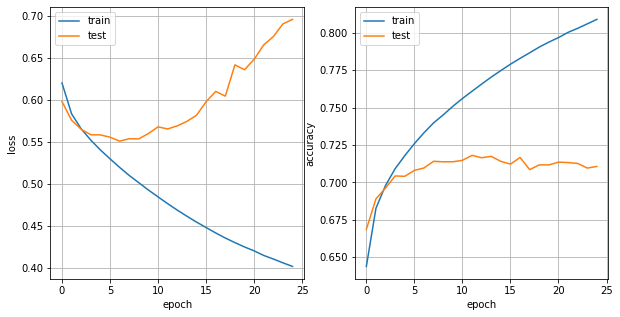

In [10]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_loss_history, label = "train")
ax.plot(test_loss_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()
ax.grid()

ax = fig.add_subplot(1, 2, 2)
ax.plot(train_accuracy_history, label = "train")
ax.plot(test_accuracy_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.legend()
ax.grid()